# Scania Truck Air Pressure Sensor Failure Analysis 

## Impoprt Libraries

In [5]:
# import libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Helper Functions

In [ ]:
def calculate_clf_performance_metrics(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) 
    f1 = f1_score(true, predicted) 
    precision = precision_score(true, predicted) 
    recall = recall_score(true, predicted) 
    roc_auc = roc_auc_score(true, predicted) 
    return acc, f1 , precision, recall, roc_auc

In [ ]:
# Create cost of the model as per data description
def calculate_total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and returns Total cost due to misclassification

    Cost-metric of miss-classification:

     Predicted class |      True class       |
                     |    pos    |    neg    |
     -----------------------------------------
      pos            |     -     |  Cost_1   |
     -----------------------------------------
      neg            |  Cost_2   |     -     |
     -----------------------------------------

     Cost_1 = 10 and cost_2 = 500
     Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.

    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [2]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=calculate_clf_performance_metrics(y_train ,y_train_pred)
        train_cost = calculate_total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=calculate_clf_performance_metrics(y_test, y_test_pred)
        test_cost = calculate_total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

## Read Data

In [53]:
# read data
df = pd.read_csv('/config/workspace/aps_failure_training_set1.csv',na_values='na')

In [54]:
# check rows and columns 
df.shape

(36188, 171)

In [55]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


## Exploratory Data Analysis - EDA

In [59]:
# check number of unique values of target column
df['class'].value_counts()

neg    35188
pos     1000
Name: class, dtype: int64

<AxesSubplot: ylabel='class'>

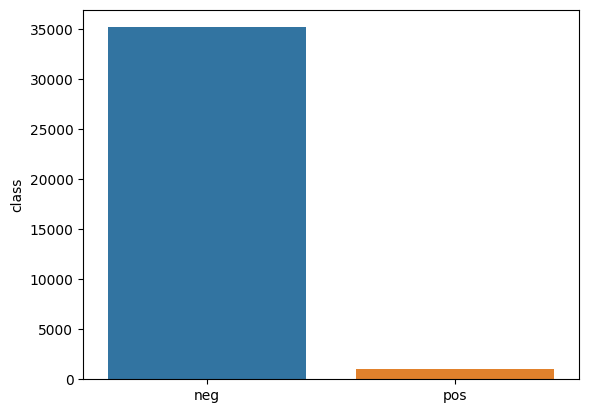

In [60]:
# visualize class feature distribution
sns.barplot(x =df['class'].value_counts().index , y = df['class'].value_counts())

In [62]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} categorical features : {}'.format(len(categorical_features), categorical_features))
print('\nWe have {} numerical features : {}'.format(len(numeric_features), numeric_features))

We have 1 categorical features : ['class']

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_

Note: As this is a sensor base data interpretation of each columns is not required. Instead we will check the distribution of the missing values in each column.

In [87]:
# check missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'number_of_missing' : df.isnull().sum(),
                                 'percent_missing': percent_missing})
missing_value_df = missing_value_df.sort_values('percent_missing',ascending=False)
missing_value_df

,number_of_missing,percent_missing
br_000,29461,81.410965
bq_000,29132,80.501824
bp_000,28514,78.794075
ab_000,27896,77.086327
cr_000,27896,77.086327
...,...,...
cj_000,203,0.560959
ci_000,203,0.560959
bt_000,86,0.237648
aa_000,0,0.000000


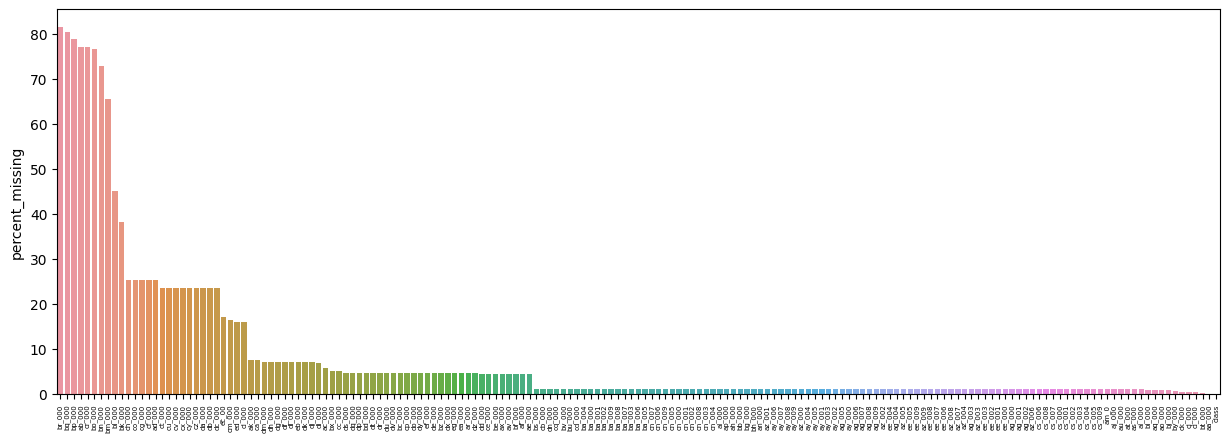

In [85]:
#visualize missing values
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x = missing_value_df.index, y= missing_value_df['percent_missing'] )
plt.xticks(fontsize=5, rotation=90)
plt.show()

In [90]:
# drop columns which has more than %70 of missing values
drop_column_list  = list(missing_value_df[missing_value_df['percent_missing']>70].index)
drop_column_list

['br_000', 'bq_000', 'bp_000', 'ab_000', 'cr_000', 'bo_000', 'bn_000']

In [91]:
df = df.drop(drop_column_list, axis=1)

In [93]:
# check rows and columns after droping columns 
df.shape

(36188, 164)

#### Observations:

* The target column 'class' is highly imbalanced which needs to be handled.

* Interpreting each and every column is not necessary as this is sensor data.

* Remaining missing values need to be handled as well.

##  Modelling 

In [ ]:
# Splitting X and y
X = df.drop('class', axis=1)
y = df['class

# encoding target variable
y= y.replace({'pos': 1, 'neg': 0})']

In [9]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier() }

NameError: name 'RandomForestClassifier' is not defined

# Experiment 1 : 

Scaling approach : Robust scaler  

Null value approach : KNN Imputer

Imbalanced handling approach : SMOTE+TOMEK 

In [ ]:
# Experiment 2 : 

Scaling approach :  

Null value approach : 

Imbalanced handling approach :

In [ ]:
# Experiment 3 : 

Scaling approach :  

Null value approach : 

Imbalanced handling approach :

In [ ]:
# Experiment 4 : 

Scaling approach :  

Null value approach : 

Imbalanced handling approach :

In [ ]:
# Experiment 5 : 

Scaling approach :  

Null value approach : 

Imbalanced handling approach :